In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pymysql
import getpass
import matplotlib.pyplot as plt
import statsmodels.api as sm

pd.set_option('display.max_rows', 500)
%matplotlib inline
sns.set()
sns.set_style("ticks")

In [2]:
pw = getpass.getpass()

········


In [3]:
conn = pymysql.connect(host="localhost",
                       port=3306,
                       user="ironhack",
                       passwd=pw,
                       db="olist")

Olist ran a Black Friday promotion on Nov. 24th, 2018.

The Analytics team is tasked to evaluate the success.

Get weekly data for revenue:

In [4]:
revenue_query = """
    SELECT
        DATE_SUB(DATE(o.order_purchase_timestamp),
                      INTERVAL DAYOFWEEK(DATE(o.order_purchase_timestamp)) - 1 DAY) AS week_id,
        SUM(oi.price)                       AS revenue_generated
    FROM orders o
        JOIN order_items oi 
        ON o.order_id = oi.order_id
    WHERE o.order_purchase_timestamp < '20180115'
        AND o.order_purchase_timestamp > '20170305'
    GROUP BY 1
    ORDER BY 1;
"""

weekly_revenue = pd.read_sql(revenue_query, conn)

In [5]:
weekly_revenue.head()

,week_id,revenue_generated
0,2017-03-05,78704.619772
1,2017-03-12,95487.199723
2,2017-03-19,85260.389904
3,2017-03-26,83634.099916
4,2017-04-02,94745.860022


In [6]:
weekly_revenue.dtypes

week_id               object
revenue_generated    float64
dtype: object

In [7]:
weekly_revenue["week_id"] = pd.to_datetime(weekly_revenue["week_id"])

In [8]:
weekly_revenue.dtypes

week_id              datetime64[ns]
revenue_generated           float64
dtype: object

In [9]:
weekly_revenue = weekly_revenue.set_index("week_id")

## Approach 1:
Compare to time periods. In this scenario, we compare the week that had the black friday promotion with the prior week that did not have the promotion

In [10]:
week = (weekly_revenue
        .copy())

In [11]:
week_comp = week.loc["2017-11-12":"2017-11-19"]

In [12]:
week_comp

,revenue_generated
week_id,
2017-11-12,178951.390068
2017-11-19,381809.340397


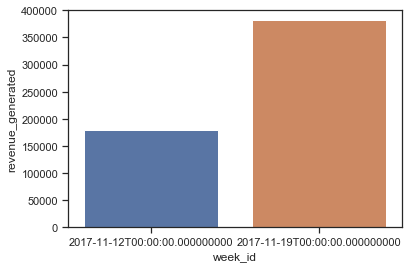

In [13]:
sns.barplot(data=week_comp,
            x=week_comp.index,
            y="revenue_generated");

Calculating difference:

In [14]:
abs_diff = week_comp.loc["2017-11-19", "revenue_generated"] - week_comp.loc["2017-11-12", "revenue_generated"] - 1
rel_diff = week_comp.loc["2017-11-19", "revenue_generated"] / week_comp.loc["2017-11-12", "revenue_generated"] - 1
print(f"""The revenue for the week including black friday increase by {round(rel_diff*100)}% compared to the week before
Assuming the black friday promotion accounts for the entire difference, we were able to increase revenue by {round(abs_diff)} Rios
""")

The revenue for the week including black friday increase by 113.0% compared to the week before
Assuming the black friday promotion accounts for the entire difference, we were able to increase revenue by 202857.0 Rios



---

Now let's take a look at the time series to do a visual inspection

/Users/at/miniconda3/envs/day1/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


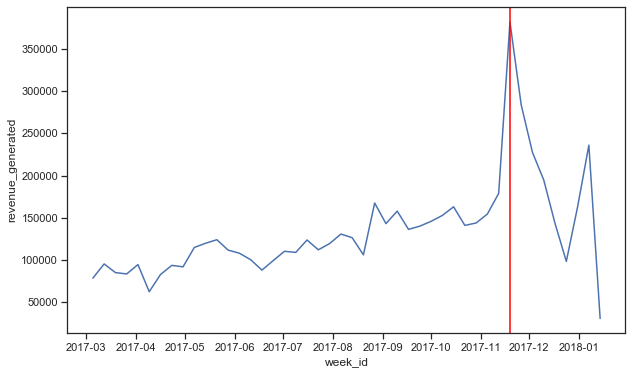

In [15]:
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(data=weekly_revenue,
             x=weekly_revenue.index,
             y="revenue_generated",
             ax=ax);

# add vertical line during black friday week
ax.axvline("2017-11-19", 0, 350000, color="red");

We can see that the week of black friday significantly increased revenue. The graph however looks like revenue declined to a lower level than before in the few weeks after the sale. We might want to account for the loss of revenue in the following weeks as consumers might have preponed purchases to black friday to get a sale (referred to as hangover, cannibalism, or "moving sales" from a later point to an earlier point)

## Approach 2: 

Simple comparison but with more weeks to account for hangover

In [16]:
weekly_revenue.head()

,revenue_generated
week_id,
2017-03-05,78704.619772
2017-03-12,95487.199723
2017-03-19,85260.389904
2017-03-26,83634.099916
2017-04-02,94745.860022


In [17]:
week_hangover = (weekly_revenue
                 .copy()
                 .loc["2017-11-12":"2017-12-31"])

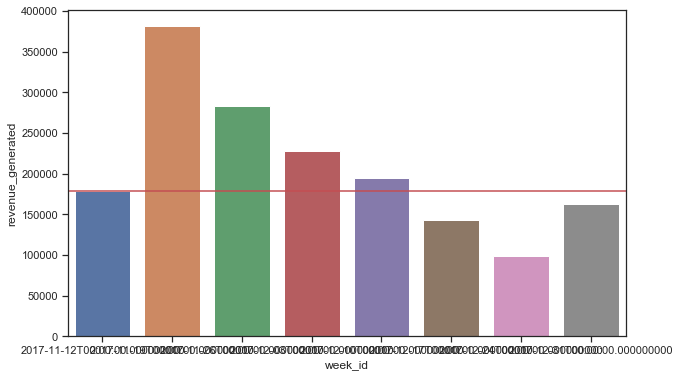

In [18]:
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(data=week_hangover,
            x=week_hangover.index,
            y="revenue_generated",
            ax=ax);

ax.axhline(week_hangover.loc["2017-11-12", "revenue_generated"], color="r");

Visually, it looks like revenue was slowly declining after black friday up to a point where it was below previous weekly revenue. It appears to recover in the last week of 2017/first week of 2018. 
Assuming that the one week prior to black friday is a valid benchmark, we can now compute the difference between each subsequent week and our benchmark and calculate the cumulative sum as our total black friday revenue increase. This is equivalent to assuming that without black friday, our weekly revenue would have been exactly the same as in the one week prior to black friday

In [19]:
rev_reference_week = week_hangover.loc["2017-11-12", "revenue_generated"]
rev_subsequent_weeks = week_hangover.loc["2017-11-19":, "revenue_generated"]

In [20]:
total_rev = rev_subsequent_weeks.to_frame().assign(predicted_revenue=rev_reference_week).sum()
abs_diff = total_rev["revenue_generated"] - total_rev["predicted_revenue"]
rel_diff = (total_rev["revenue_generated"] / total_rev["predicted_revenue"]) - 1
print(f"""Assuming that without black friday sale, our weekly sales would have stayed at 179K,
we generated an additional {int(abs_diff)} Rios total revenue over the week of black friday until the end of the year,
which approximately represents a {round(rel_diff*100)}% increase in revenue""")

Assuming that without black friday sale, our weekly sales would have stayed at 179K,
we generated an additional 239666 Rios total revenue over the week of black friday until the end of the year,
which approximately represents a 19.0% increase in revenue


### _Lab exercise_
We could do the same exercise accounting for a handful of weeks prior to black friday, adding the assumption that people postponed purchases to black friday that they would have otherwise done prior due to the expected lower prices. 

---

## Approach 3: Accounting for trends / seasonality

So far, we have always used one prior week as a benchmark for predicted revenue assuming. 
As can clearly be seen by the line graph, revenue has already had a positive trend when looking at the data starting from March. In case of a positive trend, we might have overestimated the impact of black friday as part of the increase could plausbily be attributed to the general growth of olist.

In the following, we want to model `revenue_generated` as a linear function that depends on time so that we can account for trends.

$$revenue\_generated_t = c + (t_t*trend)$$

This approach adds a so-called "fitted line" to the time series.

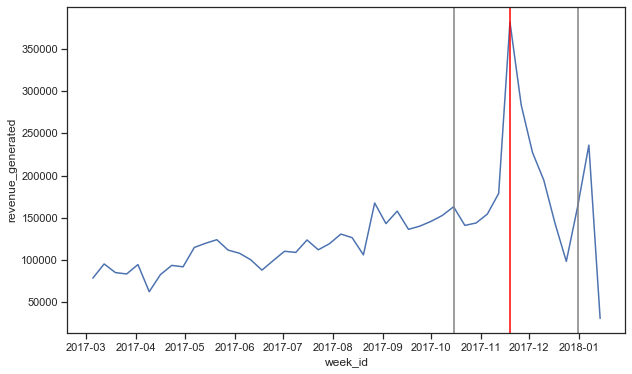

In [21]:
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(data=weekly_revenue,
             x=weekly_revenue.index,
             y="revenue_generated",
             ax=ax);

ax.axvline("2017-10-15", 0, 350000, color="grey");
ax.axvline("2017-12-31", 0, 350000, color="grey");
ax.axvline("2017-11-19", 0, 350000, color="red");

Looking at the graph, we now want to find a fitting model to then forecast revenue for the weeks that might have been affected by black friday. In this case, we account for both weeks prior and after to black friday to get a more conservative estimate. We assume the area between they grey borders (from 2017-10-15 until 2017-12-31) were affected and need to be forecasted and compared.

The fitted line could get biased by the data collected during black friday and the few prior and subsqeuent weeks. In order to get a fairer comparison, we pretend that we only had data up until the day before Black Friday, we then forecast `revenue` given our fitted model and then compare our forecasts with the actual values

In [22]:
# create time variable
rev_trend = weekly_revenue.assign(t=range(1, len(weekly_revenue) + 1))
rev_trend.head()

,revenue_generated,t
week_id,,
2017-03-05,78704.619772,1
2017-03-12,95487.199723,2
2017-03-19,85260.389904,3
2017-03-26,83634.099916,4
2017-04-02,94745.860022,5


Calculate fitted line

In [23]:
# add constant
rev_train = rev_trend[:"2017-10-15"].copy()
rev_train = sm.add_constant(rev_train)

X = rev_train[["const", "t"]]
y = rev_train["revenue_generated"]
lin_reg = sm.OLS(y, X)
results = lin_reg.fit()

/Users/at/miniconda3/envs/day1/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [24]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      revenue_generated   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.726
Method:                 Least Squares   F-statistic:                     85.87
Date:                Sun, 10 Nov 2019   Prob (F-statistic):           1.91e-10
Time:                        20:27:33   Log-Likelihood:                -360.08
No. Observations:                  33   AIC:                             724.2
Df Residuals:                      31   BIC:                             727.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7.522e+04   4873.597     15.435      0.000    6.53e+04    8.52e+04
t           2317.8239    250.120      9.267      0.000    1807.701    2827.947
==============================================================================
Omnibus:                        0.360   Durbin-Watson:                   1.594
Prob(Omnibus):                  0.835   Jarque-Bera (JB):                0.032
Skew:                           0.072   Prob(JB):                        0.984
Kurtosis:                       3.053   Cond. No.                         40.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Plot fitted line

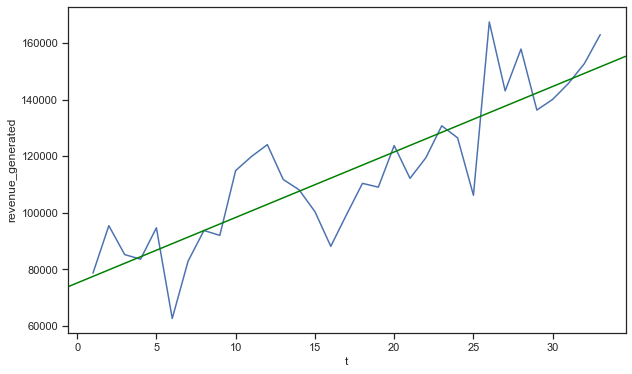

In [25]:
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(data=rev_train,
             x="t",
             y="revenue_generated",
             ax=ax);

sm.graphics.abline_plot(model_results=results, color="green", ax=ax);

Let's compute the forecast based on this model to see how the fitted line would look like given the actual values for the time period affected by black friday

In [26]:
predicted_revenue = results.predict(sm.add_constant(rev_trend)[["const", "t"]])
rev_pred = rev_trend.assign(predicted_revenue=predicted_revenue)

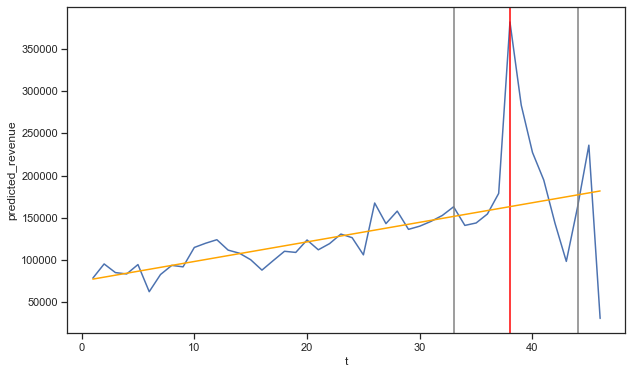

In [27]:
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(data=rev_trend,
             x="t",
             y="revenue_generated",
             ax=ax);

ax.axvline(rev_trend.loc["2017-10-15", "t"], 0, 350000, color="grey");
ax.axvline(rev_trend.loc["2017-12-31", "t"], 0, 350000, color="grey");
ax.axvline(rev_trend.loc["2017-11-19", "t"], 0, 350000, color="red");

sns.lineplot(data=rev_pred,
             x="t",
             y="predicted_revenue",
             color="orange",
             ax=ax);

Given this model, we can now calculate the differences between the actual observations (blue) and the predicted (orange). The difference is due to black friday according to our assumptions.

In [28]:
black_friday = rev_pred.loc["2017-10-15":"2017-12-31"]
rev_diff = black_friday["revenue_generated"] - black_friday["predicted_revenue"]

black_friday = black_friday.assign(rev_diff=rev_diff)

In [29]:
sums = black_friday[["revenue_generated",
                     "predicted_revenue",
                     "rev_diff"]].sum()

print(f"""According to this model, black friday accounted for a total of {int(sums['rev_diff'])} Rios of additional revenue.
This represents a relative increase of approx. {round((sums["revenue_generated"] / sums["predicted_revenue"] - 1) * 100)}% compared to our foreacast""")

According to this model, black friday accounted for a total of 300467 Rios of additional revenue.
This represents a relative increase of approx. 15.0% compared to our foreacast


---

## Approach 4:
Fit a quadratic line

In [30]:
# create time variable
rev_quadr = weekly_revenue.assign(t=range(1, len(weekly_revenue) + 1))
rev_quadr = rev_quadr.assign(t_sq=rev_quadr["t"]**2)
rev_quadr.head()

,revenue_generated,t,t_sq
week_id,,,
2017-03-05,78704.619772,1,1
2017-03-12,95487.199723,2,4
2017-03-19,85260.389904,3,9
2017-03-26,83634.099916,4,16
2017-04-02,94745.860022,5,25


In [31]:
# add constant
rev_train_quadr = rev_quadr[:"2017-10-15"].copy()
rev_train_quadr = sm.add_constant(rev_train_quadr)

X = rev_train_quadr[["const", "t", "t_sq"]]
y = rev_train_quadr["revenue_generated"]
lin_reg_quadr = sm.OLS(y, X)
results_quadr = lin_reg_quadr.fit()
results_quadr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      revenue_generated   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     44.65
Date:                Sun, 10 Nov 2019   Prob (F-statistic):           1.02e-09
Time:                        20:27:34   Log-Likelihood:                -359.20
No. Observations:                  33   AIC:                             724.4
Df Residuals:                      30   BIC:                             728.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.263e+04   7522.907     10.984      0.000    6.73e+04     9.8e+04
t           1048.2097   1020.140      1.028      0.312   -1035.195    3131.614
t_sq          37.3416     29.107      1.283      0.209     -22.103      96.787
==============================================================================
Omnibus:                        1.407   Durbin-Watson:                   1.679
Prob(Omnibus):                  0.495   Jarque-Bera (JB):                0.549
Skew:                           0.253   Prob(JB):                        0.760
Kurtosis:                       3.379   Cond. No.                     1.63e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [32]:
predicted_revenue_q = results_quadr.predict(sm.add_constant(rev_quadr)[["const", "t", "t_sq"]])
rev_pred_q = rev_quadr.assign(predicted_revenue=predicted_revenue_q)

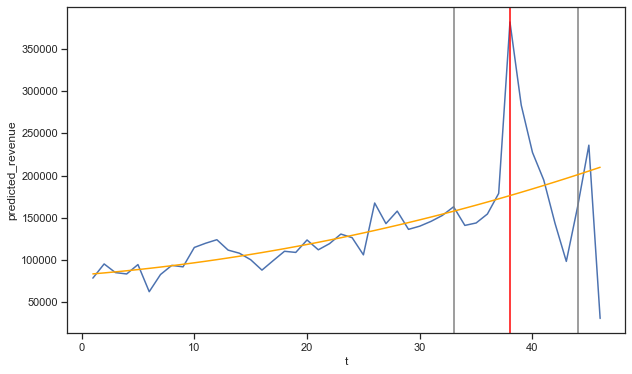

In [33]:
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(data=rev_quadr,
             x="t",
             y="revenue_generated",
             ax=ax);

ax.axvline(rev_trend.loc["2017-10-15", "t"], 0, 350000, color="grey");
ax.axvline(rev_trend.loc["2017-12-31", "t"], 0, 350000, color="grey");
ax.axvline(rev_trend.loc["2017-11-19", "t"], 0, 350000, color="red");

sns.lineplot(data=rev_pred_q,
             x="t",
             y="predicted_revenue",
             color="orange",
             ax=ax);

In [34]:
black_friday_q = rev_pred_q.loc["2017-10-15":"2017-12-31"]
rev_diff_q = black_friday_q["revenue_generated"] - black_friday_q["predicted_revenue"]

black_friday_q = black_friday_q.assign(rev_diff=rev_diff_q)

In [35]:
sums_q = black_friday_q[["revenue_generated",
                         "predicted_revenue",
                         "rev_diff"]].sum()

print(f"""According to this model, black friday accounted for a total of {int(sums_q['rev_diff'])} Rios of additional revenue.
This represents a relative increase of approx. {round((sums_q["revenue_generated"] / sums_q["predicted_revenue"] - 1) * 100)}% compared to our foreacast""")

According to this model, black friday accounted for a total of 128621 Rios of additional revenue.
This represents a relative increase of approx. 6.0% compared to our foreacast


### Lab

Run the analysis yourself (quadratic time variable):
1. Plot the time series and draw a vertical line where the week of black friday is
2. Determine the time range you think is affected by the sale, assuming that customers altered their behaviour (preponed and postponed the purchase to the weeks of black friday)
3. Create the time variables in your dataframe
4. Create a constant
5. Subset the dataframe with only the data up until the time range affected that you will use to fit your model
6. Fit your model using linear regression
7. Use your model to predict revenue for the time period affected
8. Compare predictions to actual revenue to estimate the impact of black friday on revenue
9. Summarize